In [79]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import numpy.matlib


from sklearn import preprocessing
from theano import shared
from scipy.special import expit as logistic

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [34]:
RANDOM_SEED = 8724
np.random.seed(8724)

In [3]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.8.2
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



# Chapter 11 God Spiked the Integers

## 11.1. Binomial regression

**Logistic regression** is the common name when the data are organized into single-trial cases, such that the outcome variable can only take values 0 and 1.

When individual trials with the same covariate values are instead aggregated together, it is common to speak of an **aggregated binomial regression**. In this case, the outcome can take the value zero or any positive integer up to n, the number of trials.

### 11.1.1. Logistic regression: Prosocial chimpanzees.

### Code 11.1

In [7]:
# load data
df = pd.read_csv("Data/chimpanzees.csv", sep=";")

# focus on pulled_left as the outcome to predict, 
# with prosoc_left and condition as predictor variables. 
# The outcome pulled_left is a 0 or 1 indicator that 
# the focal animal pulled the left-hand lever. 
# The predictor prosoc_left is a 0/1 indicator that 
# the left-hand lever was (1) or was not (0) attached 
# to the prosocial option, the side with two pieces of food. 
# The condition predictor is another 0/1 indicator, 
# with value 1 for the partner condition and value 0 for the control condition.
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


1. prosoc_left = 0 and condition = 0: Two food items on right and no partner.
2. prosoc_left = 1 and condition = 0: Two food items on left and no partner.
3. prosoc_left = 0 and condition = 1: Two food items on right and partner present.
4. prosoc_left = 1 and condition = 1: Two food items on left and partner present.

### Code 11.2

In [9]:
# change "actor" to zero-index
df['actor'] = df['actor'] - 1

In [10]:
df['treatment'] = df['prosoc_left'] + 2*df['condition']

### Code 11.3

In [11]:
df[['actor', 'prosoc_left', 'condition', 'treatment']]

,actor,prosoc_left,condition,treatment
0,0,0,0,0
1,0,0,0,0
2,0,1,0,1
3,0,0,0,0
4,0,1,0,1
...,...,...,...,...
499,6,1,1,3
500,6,1,1,3
501,6,0,1,2
502,6,0,1,2


## Code 11.4 and Code 11.5

In [55]:
# define model: pulled_left ~ actor
with pm.Model() as m11_1a:
    a = pm.Normal('a', mu=0, sd=10)
    p = pm.Deterministic('p', pm.math.invlogit(a))  
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    trace_m11_1a = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    prior_m11_1a = pm.sample_prior_predictive(samples=10000, random_seed=RANDOM_SEED)
    
with pm.Model() as m11_1b:
    a = pm.Normal('a', mu=0, sd=1.5)
    p = pm.Deterministic('p', pm.math.invlogit(a))  
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    trace_m11_1b = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    prior_m11_1b = pm.sample_prior_predictive(samples=10000, random_seed=RANDOM_SEED)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 6334.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 5971.78draws/s]


### Code 11.6

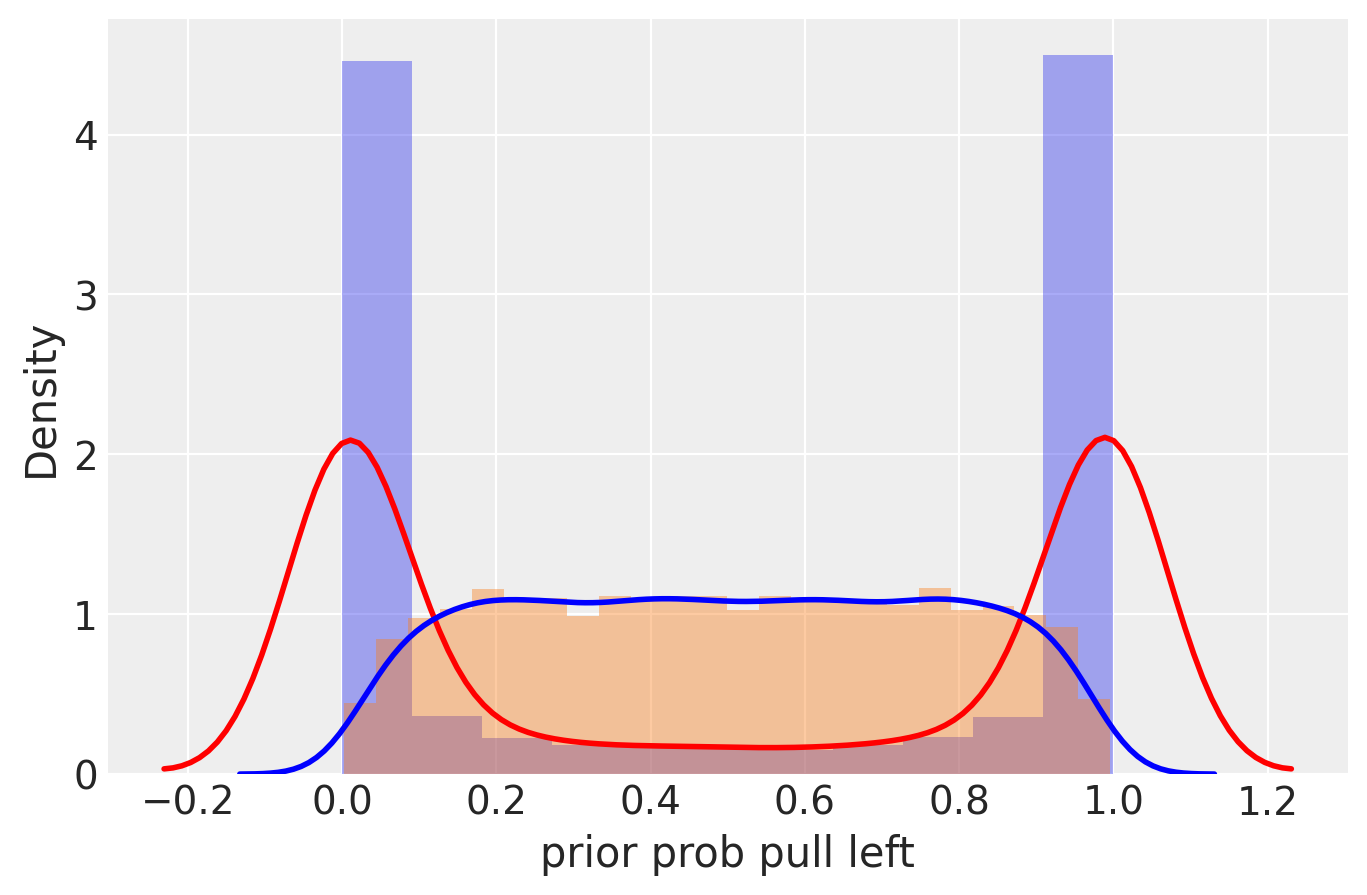

In [56]:
# plot figure
fig = plt.figure(figsize=(8, 5))
sns.distplot(prior_m11_1a['p'], hist = True, kde = True, kde_kws = {'linewidth': 2, 'color': 'r'})
sns.distplot(prior_m11_1b['p'], hist = True, kde = True, kde_kws = {'linewidth': 2, 'color': 'b'})
plt.ylabel('Density', fontsize=15)
plt.xlabel('prior prob pull left', fontsize=15)
plt.show()

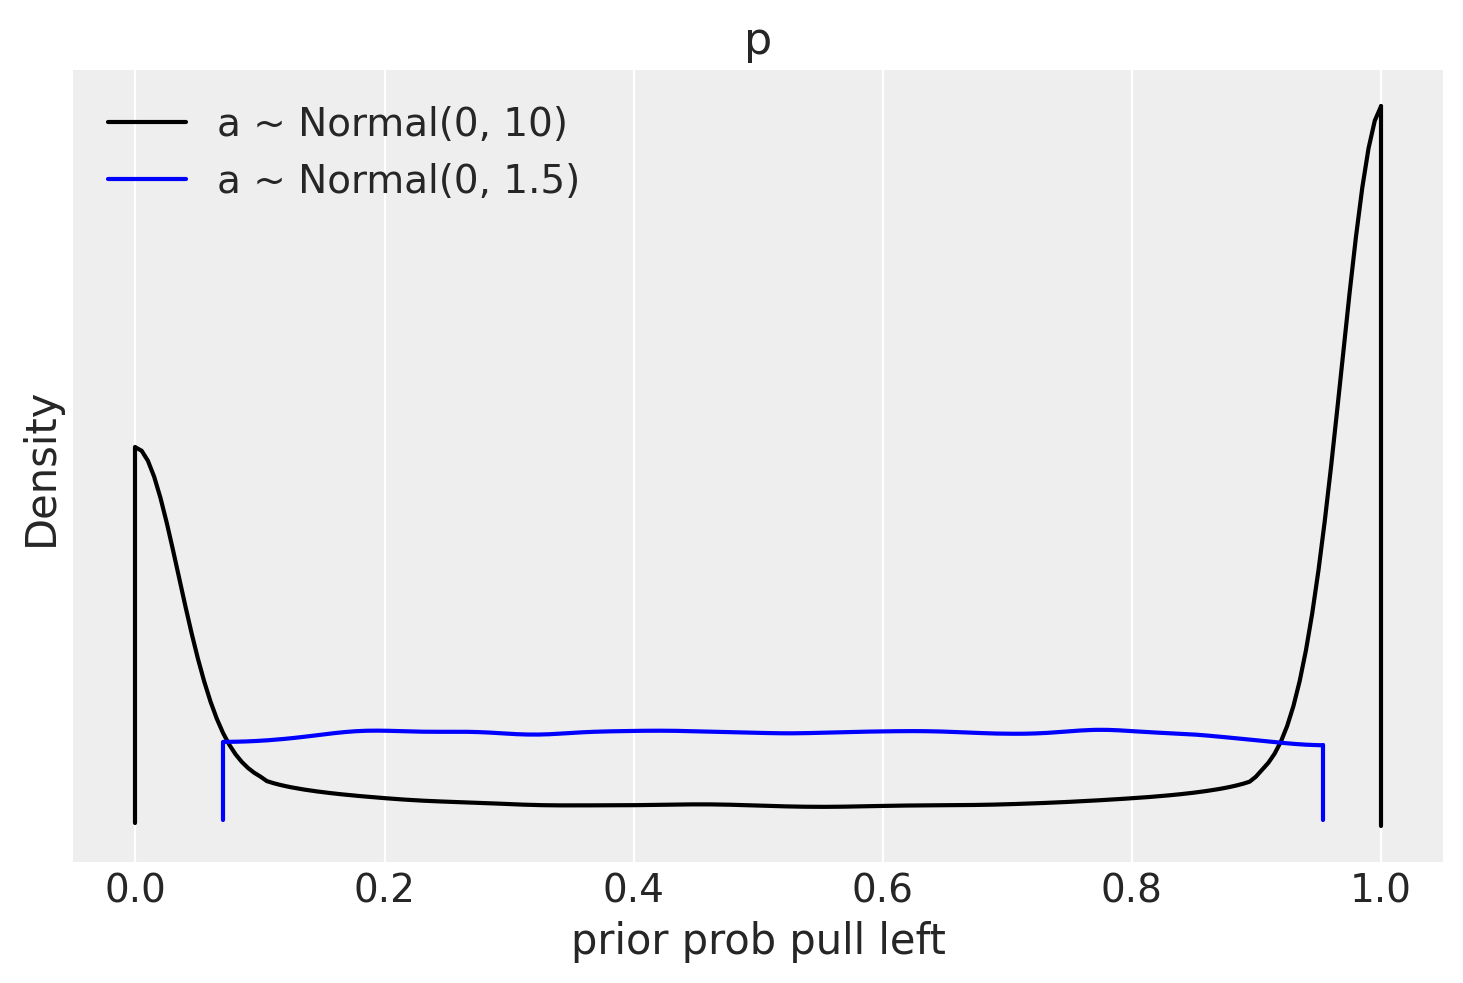

In [57]:
az.plot_density(
    [az.from_pymc3(prior=prior_m11_1a), az.from_pymc3(prior=prior_m11_1b)],
    data_labels=["a ~ Normal(0, 10)", "a ~ Normal(0, 1.5)"],
    group="prior",
    colors=["k", "b"],
    var_names=["p"],
    point_estimate=None,
)
plt.ylabel('Density', fontsize=15)
plt.xlabel('prior prob pull left', fontsize=15)
plt.show()

### Code 11.7

In [61]:
# define model: pulled_left ~ treatment
with pm.Model() as m11_2a:
    a = pm.Normal('a', mu=0, sd=1.5)
    b = pm.Normal('b', mu=0, sd=10, shape=df['treatment'].max()+1)
    p = pm.Deterministic('p', pm.math.invlogit(a + b[df['treatment'].values]))  
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    trace_m11_2a = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    prior_m11_2a = pm.sample_prior_predictive(samples=10000, random_seed=RANDOM_SEED)

with pm.Model() as m11_2b:
    a = pm.Normal('a', mu=0, sd=1.5)
    b = pm.Normal('b', mu=0, sd=0.5, shape=df['treatment'].max()+1)
    p = pm.Deterministic('p', pm.math.invlogit(a + b[df['treatment'].values]))  
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    trace_m11_2b = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    prior_m11_2b = pm.sample_prior_predictive(samples=10000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:08<00:00, 996.57draws/s] 
The acceptance probability does not match the target. It is 0.7203713615315736, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2158.17draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [112]:
p_a = logistic(np.matlib.repmat(prior_m11_2a['a'], df['treatment'].max()+1, 1).T + prior_m11_2a['b'])
p_b = logistic(np.matlib.repmat(prior_m11_2b['a'], df['treatment'].max()+1, 1).T + prior_m11_2b['b'])

### Code 11.8

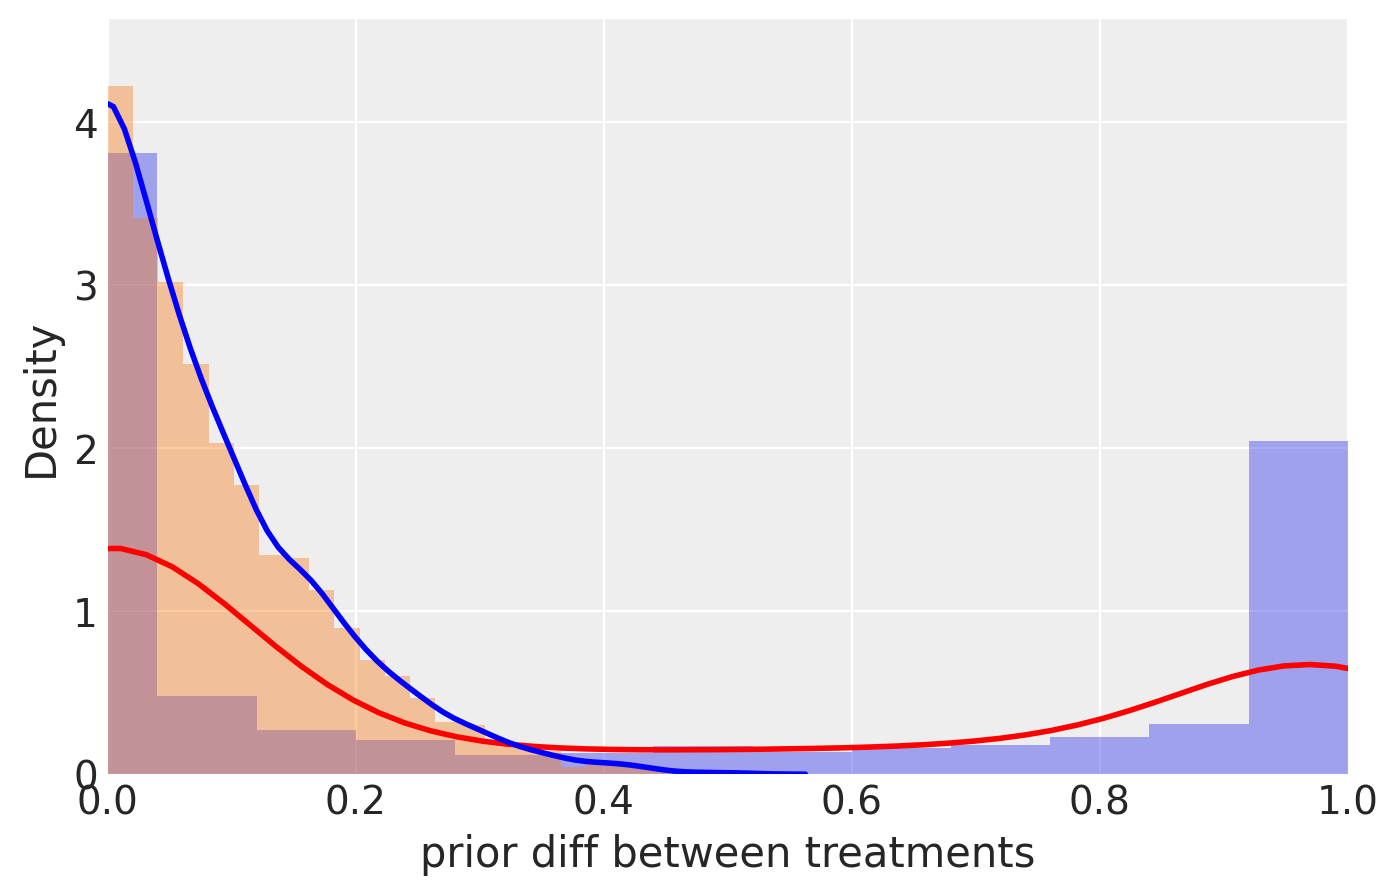

In [113]:
# plot figure
fig = plt.figure(figsize=(8, 5))
sns.distplot(p_a[:,0]-p_a[:,1], hist = True, kde = True, kde_kws = {'linewidth': 2, 'color': 'r'})
sns.distplot(p_b[:,0]-p_b[:,1], hist = True, kde = True, kde_kws = {'linewidth': 2, 'color': 'b'})
plt.ylabel('Density', fontsize=15)
plt.xlabel('prior diff between treatments', fontsize=15)
plt.xlim([0,1])
plt.show()

### Code 11.9 and Code 11.10

In [111]:
# define model: pulled_left ~ treatment + actor
with pm.Model() as m11_3:
    a = pm.Normal('a', mu=0, sd=1.5)
    b = pm.Normal('b', mu=0, sd=0.5, shape=df['treatment'].max()+1)
    p = pm.Deterministic('p', pm.math.invlogit(a + b[df['treatment'].values]))  
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    trace_m11_3 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    prior_m11_3 = pm.sample_prior_predictive(samples=10000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2403.93draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [120]:
p = logistic(np.matlib.repmat(prior_m11_3['a'], df['treatment'].max()+1, 1).T + prior_m11_3['b'])
np.abs(p[:,0]-p[:,1]).mean()

0.09761230229173912

In [129]:
# define model: pulled_left ~ treatment + actor
with pm.Model() as m11_4:
    a = pm.Normal('a', mu=0, sd=1.5, shape=df['actor'].max()+1)
    b = pm.Normal('b', mu=0, sd=0.5, shape=df['treatment'].max()+1)
    p = pm.Deterministic('p', pm.math.invlogit(a[df['actor'].values] + b[df['treatment'].values]))  
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    trace_m11_4 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    prior_m11_4 = pm.sample_prior_predictive(samples=10000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2407.94draws/s]


In [130]:
# show model summary
varnames = ['~p']
az.summary(trace_m11_4, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],-0.45,0.33,-0.98,0.09
a[1],3.91,0.76,2.60,5.00
a[2],-0.75,0.34,-1.31,-0.24
a[3],-0.75,0.34,-1.28,-0.19
a[4],-0.45,0.33,-1.00,0.05
a[5],0.48,0.34,-0.06,1.00
a[6],1.95,0.42,1.26,2.59
b[0],-0.04,0.29,-0.52,0.40
b[1],0.48,0.29,0.04,0.95
b[2],-0.38,0.28,-0.87,0.05


### Code 11.12

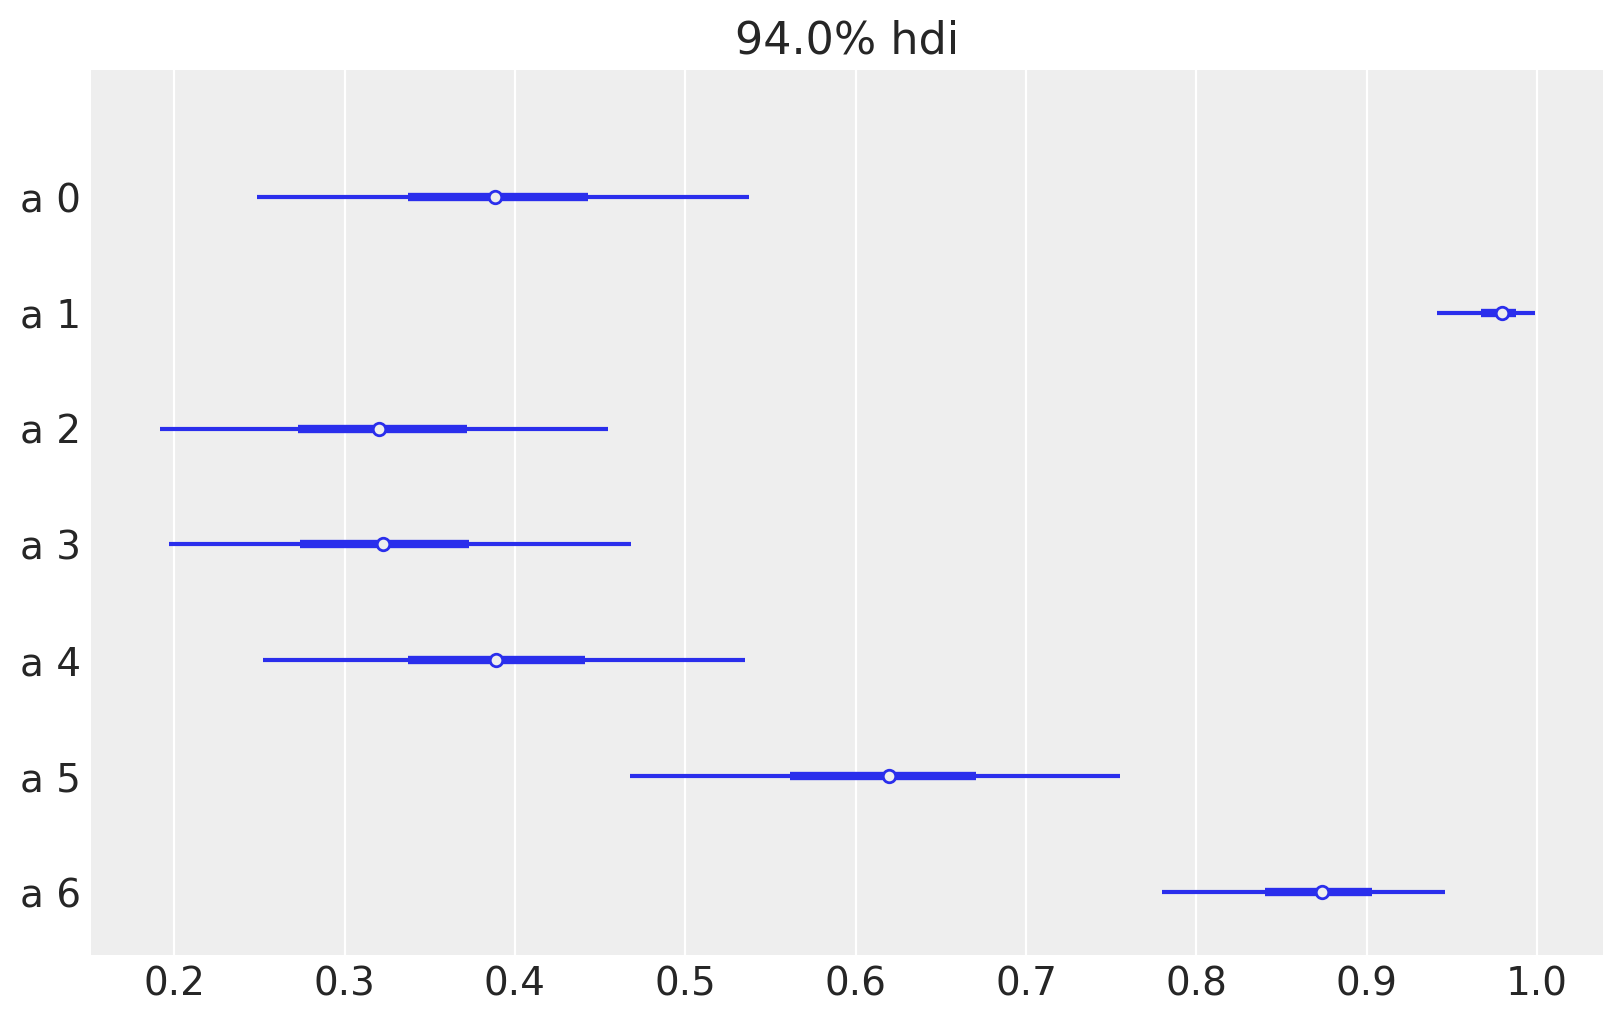

In [134]:
# plot results
axes = az.plot_forest(
    trace_m11_4,
    kind='forestplot',
    var_names=['a'],
    transform=logistic,
    combined=True,
    ridgeplot_overlap=3,
    hdi_prob=0.94,
    figsize=(8, 5))

### Code 11.13

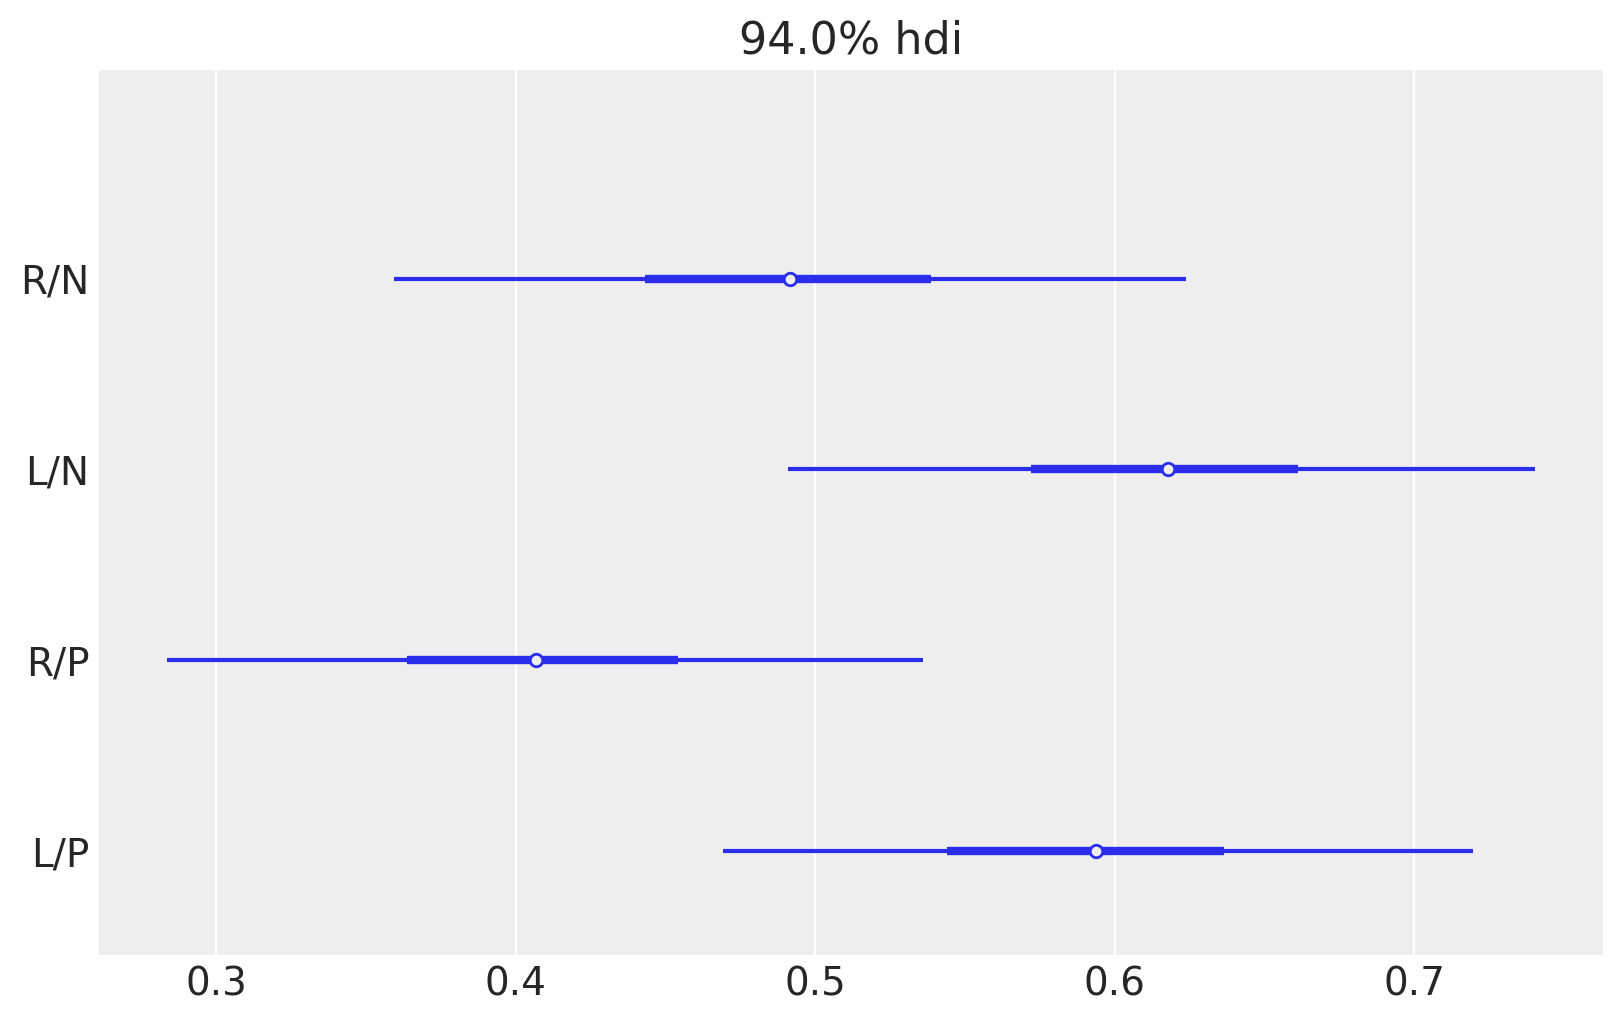

In [137]:
# plot results
axes = az.plot_forest(
    trace_m11_4,
    kind='forestplot',
    var_names=['b'],
    transform=logistic,
    combined=True,
    ridgeplot_overlap=3,
    hdi_prob=0.94,
    figsize=(8, 5))
axes[0].set_yticklabels(["L/P", "R/P", "L/N", "R/N"]);

  L/N means “prosocial on left / no partner.” R/P means ”prosocial on right / partner.” 